In [1]:
%matplotlib notebook

import numpy as np
from numpy.fft import fft, ifft, fftshift
import scipy.signal
import scipy.io.wavfile
import matplotlib.pyplot as plt

In [3]:
def plot_spect(sig, fs, window='nuttall', noverlap=256*8*2, nperseg=512*8*2, nfft=2048*16*8):
    '''Plot the power spectrum of a signal over time (waterfall plot)'''
    f, t, Sxx = scipy.signal.spectrogram(sig, fs=fs, window='nuttall',
                                     noverlap=256*8, nperseg=512*8,
                                     nfft=2048*16*8*2*4)
    plt.pcolormesh(f, t, Sxx.T)
    plt.ylabel('time')
    plt.xlabel('freq')
    plt.show()


def np2(n):
    '''Find the next power 2 number (for FFT)'''
    lg = np.log2(n)
    if lg != int(lg):
        lg = int(lg) + 1
    return int(np.power(2, lg))


def delay_sig(datin, shift):
    '''Delay a signal by shift samples'''
    Nin = len(datin) 
    N = np2(Nin +np.max(np.abs(shift)))
    fdatin = fft(datin, N)
    ik = np.array([2j*np.pi*k for k in range(0, N)]) / N 
    fshift = np.exp(-ik*shift)
    datout = np.real(np.fft.ifft(fshift * fdatin))
    datout = datout[0:Nin]
    return datout


def xcorr(x, y):
    return ifft(fft(x) * np.conj(fft(y))).real

In [4]:
noise = np.array(scipy.io.wavfile.read('./data/iono-othr1.wav')[1], dtype=np.float)
noise = np.concatenate([noise, noise])
T = 13
fs = float(len(noise)) / T
# plot_spect(noise, fs)

In [15]:
ts = np.linspace(0, T, T*fs, endpoint=False)
chirp = scipy.signal.chirp(ts, f0=2e6, t1=128*16, f1=100e6, method='linear')
sig = chirp.copy() + noise * 1e-7
# plot_spect(chirp, fs)

/home/rtse/anaconda3/envs/irss/lib/python3.6/site-packages/ipykernel_launcher.py:1: DeprecationWarning: object of type <class 'float'> cannot be safely interpreted as an integer.
  """Entry point for launching an IPython kernel.


<IPython.core.display.Javascript object>


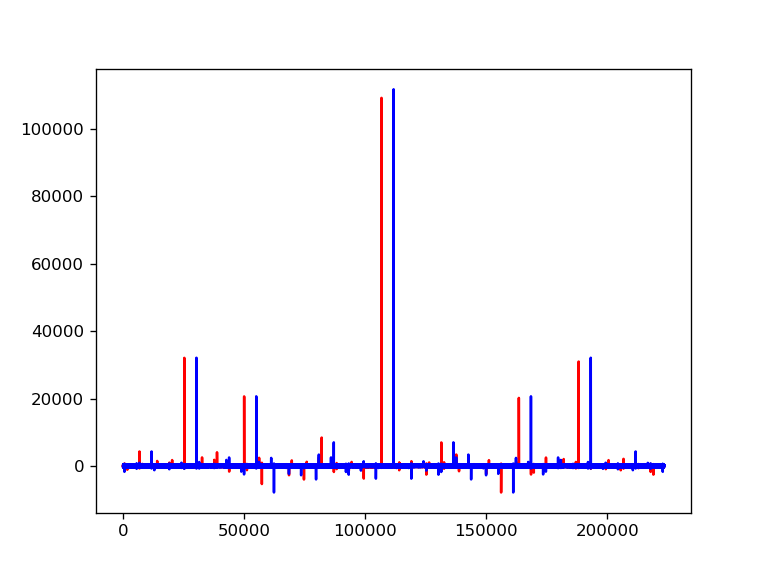

In [16]:
delayed = delay_sig(sig, 5000)
cor1 = xcorr(sig,delayed)
cor2 = xcorr(sig,sig)

plt.plot(fftshift(cor1), c='r')
plt.plot(fftshift(cor2), c='b')
plt.show()